# Vehicle Detection Project
The goals/steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

**Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vehicle_detection.constants import *

In [3]:
from vehicle_detection.helpers import load_images, visualize
cars, not_cars = load_images()
print(cars[0].shape)
print(not_cars[0].shape)

(64, 64, 3)
(64, 64, 3)


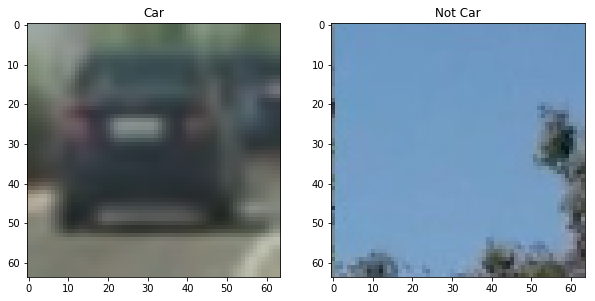

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

car_example = cars[0]
not_car_example = not_cars[0]
visualize(1, 2, [[car_example, not_car_example]], [["Car", "Not Car"]], (10, 10))
plt.savefig('output_images/car_not_car.png', bbox_inches='tight')

## Feature Extraction and Classifier Training
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

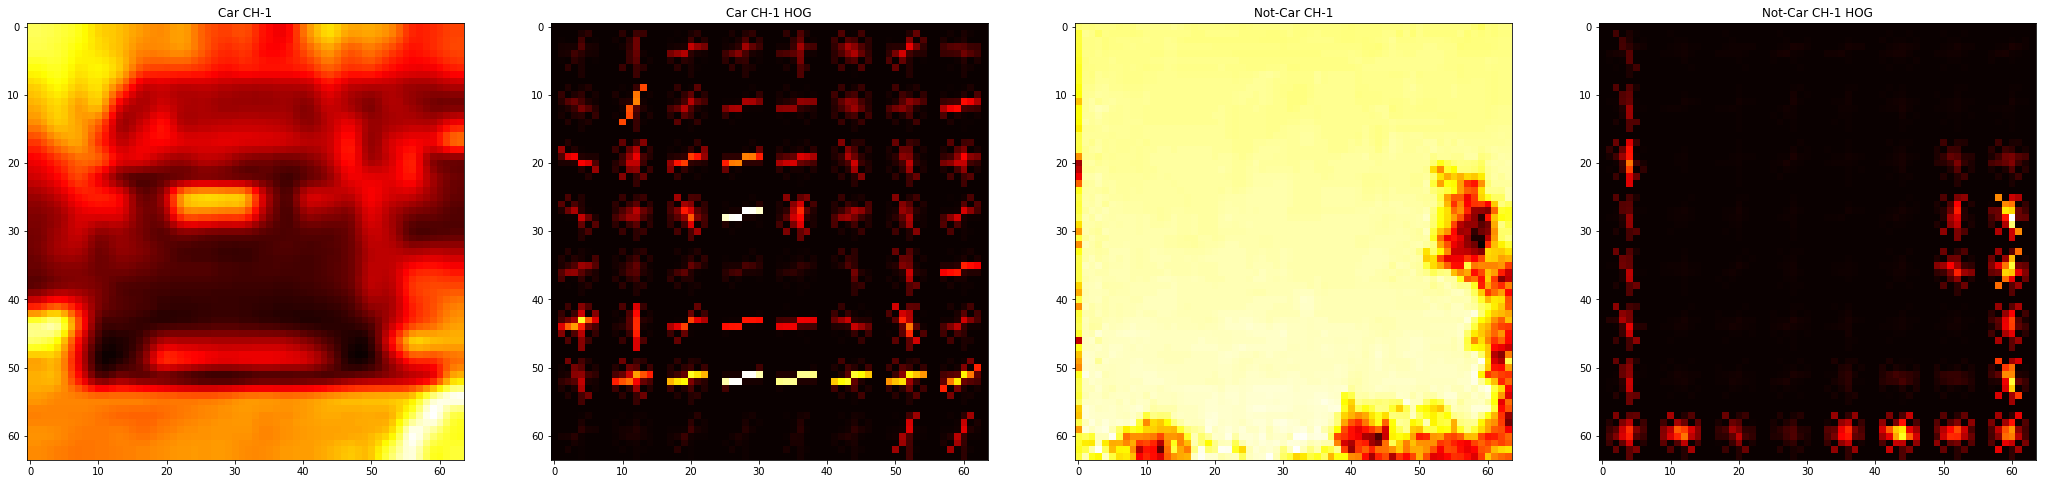

In [5]:
from skimage.feature import hog

def get_hog_features(img, orientation, pixel_per_cell, cell_per_block, visualization, feature_vector):
    return hog(img, orientations=orientation,
              pixels_per_cell=(pixel_per_cell, pixel_per_cell),
              cells_per_block=(cell_per_block, cell_per_block),
              visualise=visualization, transform_sqrt=True, feature_vector=feature_vector,
              block_norm="L2-Hys")

c_space = 'YCrCb'
ornt = 9
pix_p_cel = 8
cel_p_blc = 2
cvt_car_example_ch1 = cv2.cvtColor(car_example, COLOR_CONVERSION_CONSTANTS[c_space])[:, :, 0]
cvt_not_car_example_ch1 = cv2.cvtColor(not_car_example, COLOR_CONVERSION_CONSTANTS[c_space])[:, :, 0]
car_example_hog_features, car_example_hog_visual = get_hog_features(cvt_car_example_ch1, ornt, pix_p_cel, cel_p_blc, True, True)
not_car_example_hog_features, not_car_example_hog_visual = get_hog_features(cvt_not_car_example_ch1, ornt, pix_p_cel, cel_p_blc, True, True)
visualize(1, 4, [[cvt_car_example_ch1, car_example_hog_visual, cvt_not_car_example_ch1, not_car_example_hog_visual]],
          [["Car CH-1", "Car CH-1 HOG", "Not-Car CH-1", "Not-Car CH-1 HOG"]], (36, 20))
plt.savefig('output_images/HOG_example.png', bbox_inches='tight')

In [6]:
def normalize_features(X_train, X_test):
    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test, X_scaler

from sklearn import svm
from sklearn.model_selection import GridSearchCV

def get_classifier(X_train, y_train):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    classifier = GridSearchCV(svc, parameters, n_jobs=6, verbose=5)
    classifier.fit(X_train, y_train)
    return classifier

## Color Transformation and More Color Features
Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

In [7]:
import numpy as np

def bin_centers(histogram):
    bin_edges = histogram[1]
    return (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2

def histogram_features(img, bins=32):
    histograms_per_channel = [np.histogram(img[:, :, i], bins=bins) for i in range(img.shape[2])]
    histogram_features_per_channel = [h[0] for h in histograms_per_channel]
    return np.concatenate(histogram_features_per_channel)

import cv2

def bin_spatial(img, new_size=(32, 32)):
    return cv2.resize(img, new_size).ravel()

from sklearn.preprocessing import StandardScaler

def configure_single_image_features(color_space='RGB', spatial_size=(32, 32), histogram_bins=32, orientation=9, pixel_per_cell=8,
                              cell_per_block=2, hog_channel=0, spatial_feature=False, histogram_feature=False, hog_feature=False):
    def single_image_features_method(img):
        img_features = []
        # First convert to desired color space, assuming the image is read in with 'RGB'
        if color_space != 'RGB':
            img = cv2.cvtColor(img, COLOR_CONVERSION_CONSTANTS[color_space])
        # Then collect spatial features
        if spatial_feature:
            img_features.append(bin_spatial(img, new_size=spatial_size))
        # Then color histogram features
        if histogram_feature:
            img_features.append(histogram_features(img, histogram_bins))
        # In the end HOG features
        if hog_feature:
            if hog_channel == 'ALL':
                hog_features_per_channel = [get_hog_features(img[:, :, c], orientation, pixel_per_cell, cell_per_block, visualization=False, feature_vector=True)
                                            for c in range(img.shape[2])]
                hog_features = [h for hogs in hog_features_per_channel for h in hogs]
            else:
                hog_features = get_hog_features(img[:, :, hog_channel], orientation, pixel_per_cell, cell_per_block,
                                                visualization=False, feature_vector=True)
            img_features.append(hog_features)

        return np.concatenate(img_features)
    
    return single_image_features_method

single_image_features = configure_single_image_features(color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, histogram_bins=HISTOGRAM_BINS, orientation=ORIENTATION,
                                                        pixel_per_cell=PIXEL_PER_CELL, cell_per_block=CELL_PER_BLOCK, hog_channel=HOG_CHANNEL,
                                                        spatial_feature=SPATIAL_FEATURE, histogram_feature=HISTOGRAM_FEATURE, hog_feature=HOG_FEATURE)

print(np.array(single_image_features(cars[0])).astype(np.float64))

[  0.63954514   0.48019257   0.49649656 ...,   0.          14.81856691
  39.16403437]


### Extract Features

In [8]:
car_features = [single_image_features(i) for i in cars]
not_car_features = [single_image_features(i) for i in not_cars]

## Sliding-window Search with Classifier
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [9]:
print(len(car_features), len(not_car_features))
print(np.array(car_features[0:1]).shape)
print(np.concatenate((not_car_features[0:1], car_features[0:1])).shape)
car_features_shapes = [c.shape for c in car_features if len(c.shape) != 1]
not_car_features_shapes = [c.shape for c in not_car_features if len(c.shape) != 1]
print(car_features_shapes[0:5], not_car_features_shapes[0:5])
print(car_features[0])
print(np.array(car_features[0:1]).astype(np.float64))

8792 8968
(1, 6108)
(2, 6108)
[] []
[  0.63954514   0.48019257   0.49649656 ...,   0.          14.81856691
  39.16403437]
[[  0.63954514   0.48019257   0.49649656 ...,   0.          14.81856691
   39.16403437]]


In [10]:
from sklearn.model_selection import train_test_split

def split_to_train_and_test(X, y, test_size):
    rand_state = np.random.randint(0, 100)
    return train_test_split(X, y, test_size=test_size, random_state=rand_state)

Xs = np.vstack((car_features, not_car_features)).astype(np.float64)
ys = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

X_train, X_test, y_train, y_test = split_to_train_and_test(Xs, ys, 0.25)
X_train, X_test, X_scaler = normalize_features(X_train, X_test)
classifier = get_classifier(X_train, y_train)
print(classifier.score(X_test, y_test))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=6)]: Done   4 out of  12 | elapsed:  5.5min remaining: 11.1min
[Parallel(n_jobs=6)]: Done   7 out of  12 | elapsed:  5.7min remaining:  4.1min
[Parallel(n_jobs=6)]: Done  10 out of  12 | elapsed:  8.7min remaining:  1.7min
[Parallel(n_jobs=6)]: Done  12 out of  12 | elapsed:  8.8min finished


0.993918918919


In [11]:
from vehicle_detection.bounding_box import BoundingBox

def get_sliding_windows(image, start_point=(None, None), stop_point=(None, None), window=(64, 64), overlap_ratio=(0.5, 0.5)):
    def default_start_and_stop_point(image, st_pt, sp_pt):
        return (st_pt[0] or 0, st_pt[1] or 0), (sp_pt[0] or image.shape[1], sp_pt[1] or image.shape[0])

    start_point, stop_point = default_start_and_stop_point(image, start_point, stop_point)
    span = BoundingBox(start_point, stop_point).get_span()
    step = np.int_((window[0] * (1 - overlap_ratio[0]), window[1] * (1 - overlap_ratio[1])))
    number_of_windows = np.int_(((span[0] - window[0]) / step[0] + 1, (span[1] - window[1]) / step[1] + 1))
    window_list = []
    for x in range(number_of_windows[0]):
        for y in range(number_of_windows[1]):
            left_top = (start_point[0] + x * step[0], start_point[1] + y * step[1])
            right_bottom = (left_top[0] + window[0], left_top[1] + window[1])
            window_list.append((left_top, right_bottom))
            
    return window_list

def search_windows(image, windows, classfier, classifier_size, scaler, single_image_features_method):
    on_windows = []
    for w in windows:
        feature_image = cv2.resize(image[w[0][1]:w[1][1], w[0][0]:w[1][0]], classifier_size)
        features = single_image_features_method(feature_image)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = classfier.predict(test_features)
        if prediction == 1:
            on_windows.append(w)

    return on_windows

import matplotlib.image as mpimg
image = mpimg.imread('test_images/test3.jpg')
image = image.astype(np.float32) / 255
print(SLIDING_WINDOW_PARAMS)

import time
t1 = time.time()
sliding_window_in_groups = [get_sliding_windows(image, start_point=(None, x[0][0]), stop_point=(None, x[0][1]), window=x[1], overlap_ratio=(0.5, 0.5))
                            for x in SLIDING_WINDOW_PARAMS]
windows = [win for window_group in sliding_window_in_groups for win in window_group]
print(windows[0:10], len(windows))
hot_windows = search_windows(image, windows, classifier, (64, 64), X_scaler, single_image_features)
t2 = time.time()
print(hot_windows[0:10], len(hot_windows))
print(t2 - t1)

[((408, 480), (48, 48), (0.5, 0.5)), ((416, 544), (64, 64), (0.55000000000000004, 0.55000000000000004)), ((400, 608), (96, 96), (0.60000000000000009, 0.60000000000000009)), ((400, 656), (128, 128), (0.65000000000000013, 0.65000000000000013))]
[((0, 408), (48, 456)), ((0, 432), (48, 480)), ((24, 408), (72, 456)), ((24, 432), (72, 480)), ((48, 408), (96, 456)), ((48, 432), (96, 480)), ((72, 408), (120, 456)), ((72, 432), (120, 480)), ((96, 408), (144, 456)), ((96, 432), (144, 480))] 353
[((896, 416), (960, 480))] 1
5.155209541320801


### Heatmap

In [12]:
def accumulate_heat(heatmap, bounding_boxes):
    for b in bounding_boxes:
        heatmap[b[0][1]:b[1][1], b[0][0]:b[1][0]] += 1
        
    return heatmap

def thresholding(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

heatmap = accumulate_heat(np.zeros_like(image[:, :, 0]).astype(np.float), hot_windows)
heatmap = thresholding(heatmap, 0)

### Visulizations

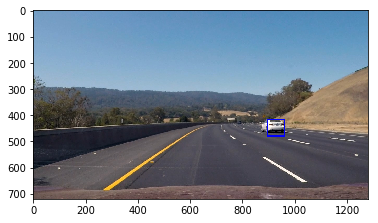

In [13]:
def draw_bounding_boxes(image, bounding_boxes, color=(0, 0, 1.0), thickness=4):
    copy = np.copy(image)
    for b in bounding_boxes:
        cv2.rectangle(copy, b[0], b[1], color, thickness)
    return copy

windows_image = draw_bounding_boxes(image, windows)
mpimg.imsave('output_images/sliding_windows.png', windows_image)

window_image = draw_bounding_boxes(image, hot_windows)
plt.imshow(window_image)

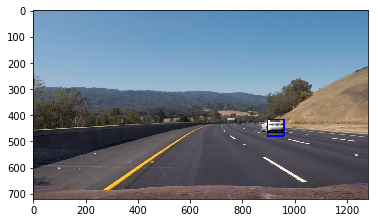

In [14]:
from scipy.ndimage.measurements import label

def draw_labeled_bounding_boxes(image, labels):
    bounding_boxes = []
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzerox, nonzeroy = np.array(nonzero[1]), np.array(nonzero[0])
        bounding_boxes.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
    copy = draw_bounding_boxes(image, bounding_boxes)
    return copy

result_image = draw_labeled_bounding_boxes(image, label(heatmap))
plt.imshow(result_image)

## Pipeline Processing
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

['test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']
[5.222890377044678, 5.195817708969116, 5.2013328075408936, 5.152202367782593, 5.179274559020996, 5.150196552276611]


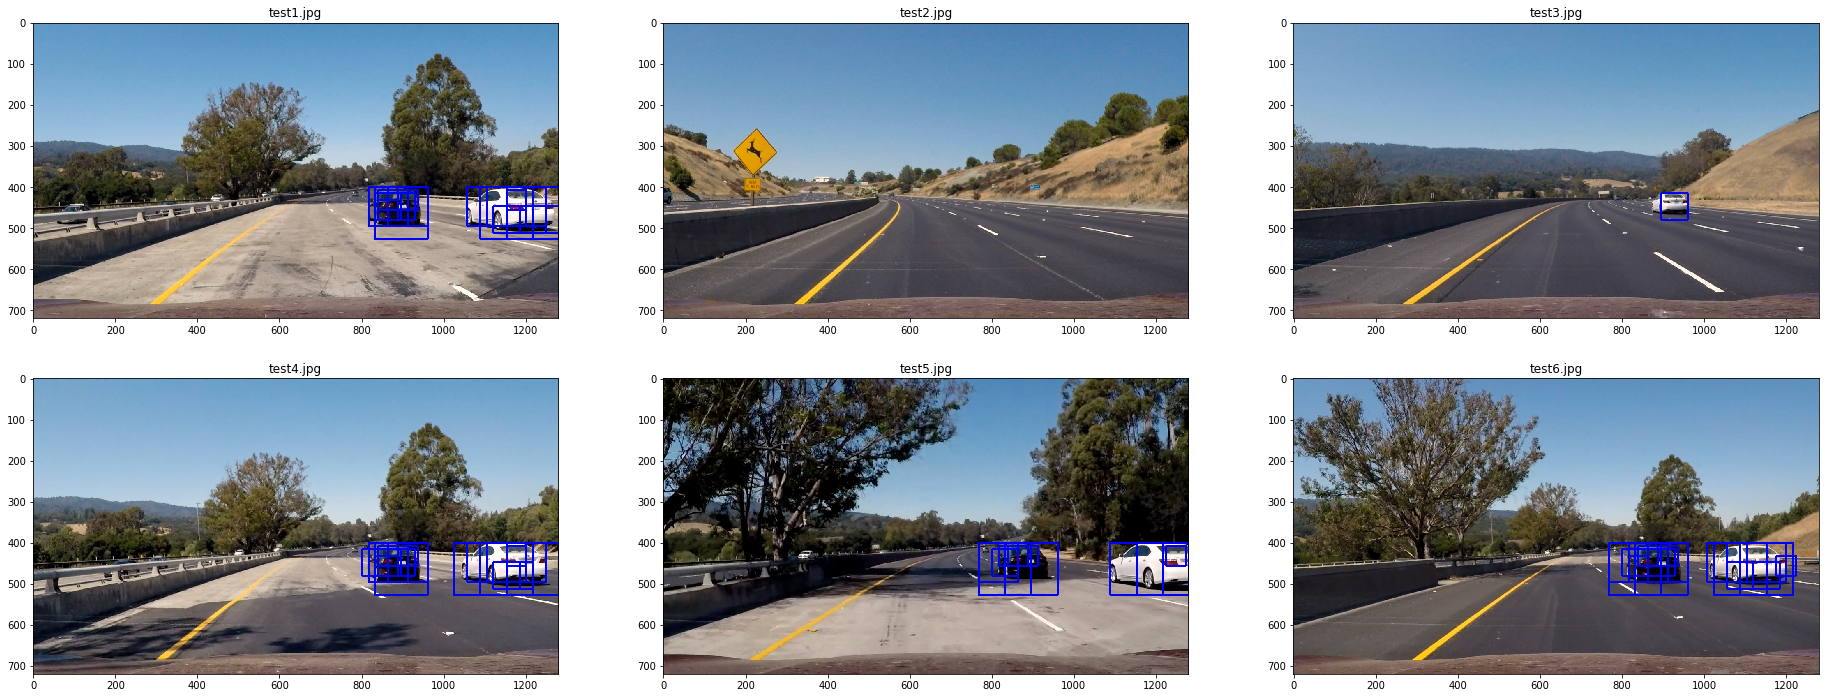

In [15]:
def process_image_method(classifier, scaler, single_image_features_method, sliding_window_params, all_found_windows_per_search, window_cache_length, heatmap_threshold,
                         result_type=2):
    def process_image(source):
        def find_hot_windows_for_image(source):
            sliding_window_groups = [get_sliding_windows(source, start_point=(None, x[0][0]), stop_point=(None, x[0][1]), window=x[1], overlap_ratio=(0.5, 0.5))
                                        for x in sliding_window_params]
            sliding_windows = [win for window_group in sliding_window_groups for win in window_group]
            return search_windows(source, sliding_windows, classifier, (64, 64), scaler, single_image_features_method)

        source = source.astype(np.float32) / 255
        # Record the positions of positive detections
        detected_windows_in_source = find_hot_windows_for_image(source)
        all_found_windows_per_search.append(detected_windows_in_source)
        latest_windows = [w for group in all_found_windows_per_search[-window_cache_length:] for w in group]
        heat_map = thresholding(accumulate_heat(np.zeros_like(source[:, :, 0]).astype(np.float), latest_windows), heatmap_threshold)
        if result_type == 0:
            result = np.clip(heat_map, 0, 255)
        elif result_type == 1:
            result = draw_bounding_boxes(source, latest_windows)
            result = (result * 255).astype(np.uint8)
        else:
            result = draw_labeled_bounding_boxes(source, label(heat_map))
            result = (result * 255).astype(np.uint8)
        return result
    
    return process_image

single_image_processor = process_image_method(classifier, X_scaler, single_image_features, SLIDING_WINDOW_PARAMS, [], 1, 0, 1)

import glob
test_image_files = glob.glob('test_images/*.jpg')
print(test_image_files)
processing_time = []
processed_images = []
for tif in test_image_files:
    source = mpimg.imread(tif)
    t1 = time.time()
    processed_image = single_image_processor(source)
    t2 = time.time()
    processing_time.append(t2 - t1)
    processed_images.append(processed_image)
    mpimg.imsave('output_images/' + tif.split('\\')[-1], processed_image, cmap='gray')
    
print(processing_time)
test_image_file_names = [tif.split('\\')[-1] for tif in test_image_files]
visualize(2, 3, [processed_images[0:3], processed_images[3:6]], [test_image_file_names[0:3], test_image_file_names[3:6]], (32, 12))
plt.savefig('output_images/sliding_window.png', bbox_inches='tight')

In [16]:
video_frame_processor = process_image_method(classifier, X_scaler, single_image_features, SLIDING_WINDOW_PARAMS, [], WINDOW_CACHE_LENGTH, HEATMAP_THRESHOLD)

In [17]:
from moviepy.editor import VideoFileClip

project_video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
lanes_clip = clip1.fl_image(video_frame_processor)
lanes_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 38/39 [03:12<00:05,  5.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [19]:
heatmap_clip = VideoFileClip("test_video.mp4")
heatmap_clip.write_images_sequence("output_images/video_frames/frame%03d.jpg")

[MoviePy] Writing frames output_images/video_frames/frame%03d.jpg.

38it [00:01, 36.92it/s]


[MoviePy]: Done writing frames output_images/video_frames/frame%03d.jpg.



['output_images/video_frames/frame000.jpg',
 'output_images/video_frames/frame001.jpg',
 'output_images/video_frames/frame002.jpg',
 'output_images/video_frames/frame003.jpg',
 'output_images/video_frames/frame004.jpg',
 'output_images/video_frames/frame005.jpg',
 'output_images/video_frames/frame006.jpg',
 'output_images/video_frames/frame007.jpg',
 'output_images/video_frames/frame008.jpg',
 'output_images/video_frames/frame009.jpg',
 'output_images/video_frames/frame010.jpg',
 'output_images/video_frames/frame011.jpg',
 'output_images/video_frames/frame012.jpg',
 'output_images/video_frames/frame013.jpg',
 'output_images/video_frames/frame014.jpg',
 'output_images/video_frames/frame015.jpg',
 'output_images/video_frames/frame016.jpg',
 'output_images/video_frames/frame017.jpg',
 'output_images/video_frames/frame018.jpg',
 'output_images/video_frames/frame019.jpg',
 'output_images/video_frames/frame020.jpg',
 'output_images/video_frames/frame021.jpg',
 'output_images/video_frames/fra

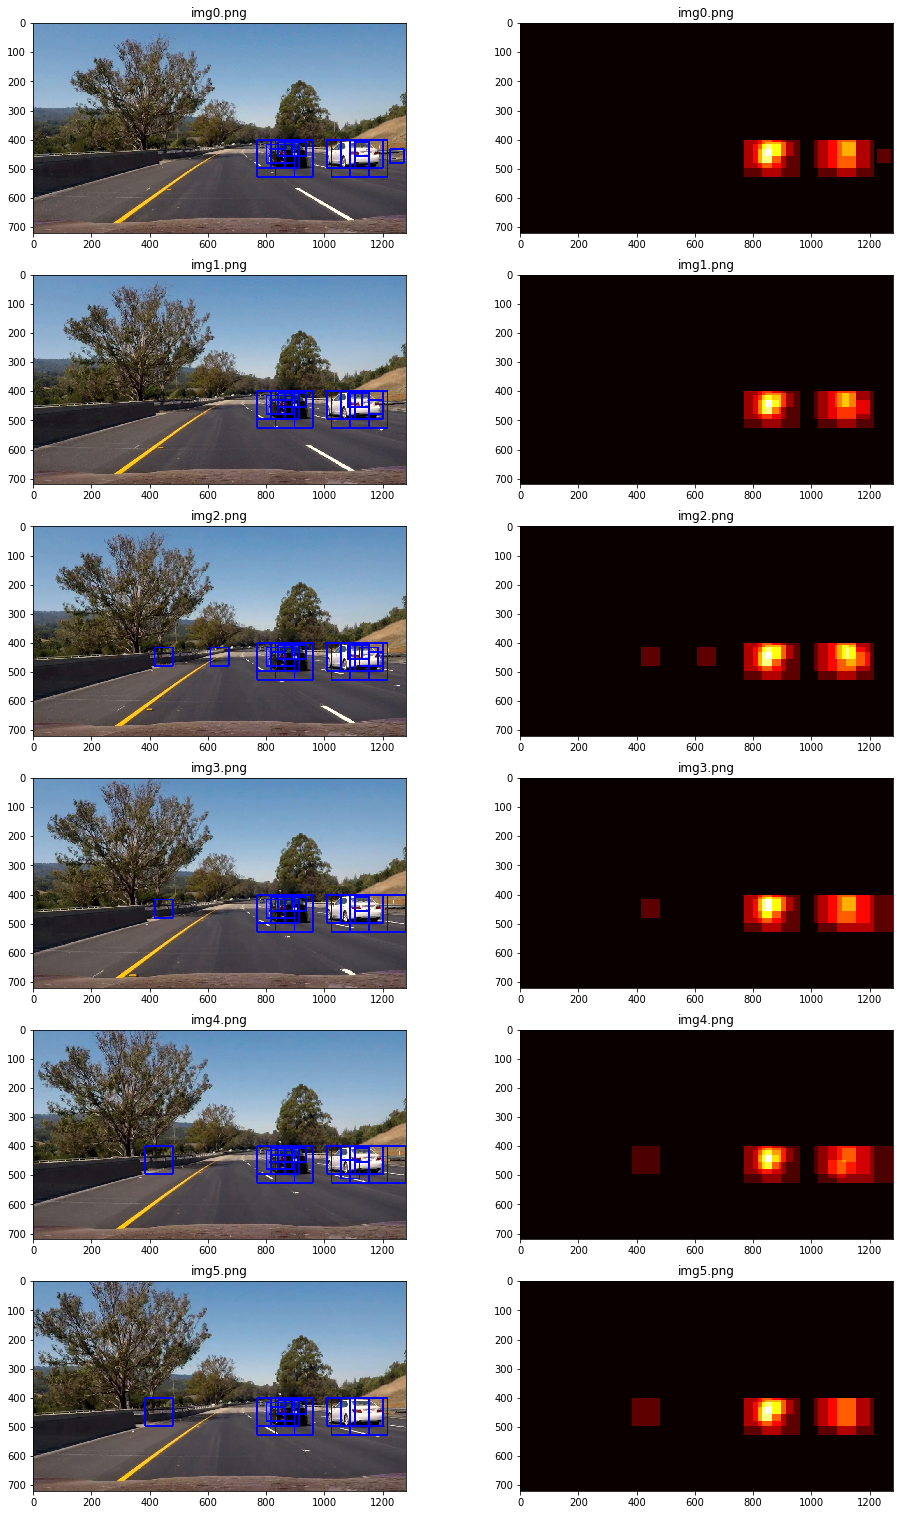

In [20]:
heatmap_processor = process_image_method(classifier, X_scaler, single_image_features, SLIDING_WINDOW_PARAMS, [], 1, 0, 0)
images_with_bounding_boxes = []
heatmap_images = []
frame_files = ['output_images/video_frames/frame00{}.jpg'.format(i) for i in range(6)]
frames = [mpimg.imread(f) for f in frame_files]
for f in frames:
    heatmap_images.append(heatmap_processor(f))
    images_with_bounding_boxes.append(single_image_processor(f))

image_titles = ['img{}.png'.format(i) for i in range(len(frames))]
visualize(len(frames), 2, list(zip(images_with_bounding_boxes, heatmap_images)), list(zip(image_titles, image_titles)), (16, 27))
plt.savefig("output_images/bboxes_and_heat.png", bbox_inches='tight')

In [23]:
multi_heatmap_processor = process_image_method(classifier, X_scaler, single_image_features, SLIDING_WINDOW_PARAMS, [], 6, 8, 0)
multi_heatmaps = [multi_heatmap_processor(f) for f in frames]
mpimg.imsave("output_images/labels_map.png", label(multi_heatmaps[-1])[0], cmap='gray')

In [24]:
mpimg.imsave("output_images/output_bboxes.png", draw_labeled_bounding_boxes(frames[-1], label(multi_heatmaps[-1])))

In [32]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(10, 15)
lanes_clip = clip1.fl_image(video_frame_processor)
lanes_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [1:43:23<00:04,  4.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



## Bounding Boxes
Estimate a bounding box for vehicles detected.

In [36]:
%who
print(HOG_CHANNEL)

BoundingBox	 CELL_PER_BLOCK	 COLOR_CONVERSION_CONSTANTS	 COLOR_SPACE	 GridSearchCV	 HEATMAP_THRESHOLD	 HISTOGRAM_BINS	 HISTOGRAM_FEATURE	 HOG_CHANNEL	 
HOG_FEATURE	 ORIENTATION	 OVERLAP_RATIOS	 PIXEL_PER_CELL	 SLIDING_WINDOW_PARAMS	 SLIDING_WINDOW_SIZES	 SPATIAL_FEATURE	 SPATIAL_SIZE	 StandardScaler	 
VideoFileClip	 WINDOW_CACHE_LENGTH	 X_scaler	 X_test	 X_train	 Xs	 Y_START_AND_STOPS	 accumulate_heat	 bin_centers	 
bin_spatial	 c_space	 car_example	 car_example_hog_features	 car_example_hog_visual	 car_features	 car_features_shapes	 cars	 cel_p_blc	 
classifier	 clip1	 configure_single_image_features	 cv2	 cvt_car_example_ch1	 cvt_not_car_example_ch1	 draw_bounding_boxes	 draw_labeled_bounding_boxes	 f	 
frames	 get_classifier	 get_frames	 get_hog_features	 get_sliding_windows	 glob	 heatmap	 heatmap_clip	 heatmap_images	 
heatmap_processor	 histogram_features	 hog	 hot_windows	 image	 image_titles	 images_with_bounding_boxes	 label	 lanes_clip	 
load_images	 mpimg	 normalize_features